<a href="https://colab.research.google.com/github/chika1911/DCGAN-MNIST-digit-generation/blob/main/DCGAN_MNIST_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import PIL
import time
from tqdm.notebook import tqdm
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

In [2]:
# loading the dataset
(x_train,y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0],28,28,1).astype('float32')
x_train = (x_train-127.5)/127.5
x_test = (x_test-127.5)/127.5
y_train= y_train.T
y_test=y_test.T

11490434/11490434 [==============================] - 0s 0us/step


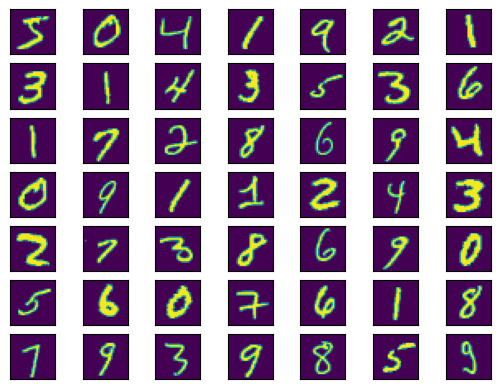

In [3]:
# printing the dataset
for i in range(49):
    # fig = plt.figure()
    # fig.add_subplot(7,7,i+1)
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(x_train[i])
    # fig = plt.figure()
    # fig.add_subplot()
    #plt.savefig('/content/output images ')
    # saveImage(fig,i)
plt.show()
#plt.savefig('my_plot.png')

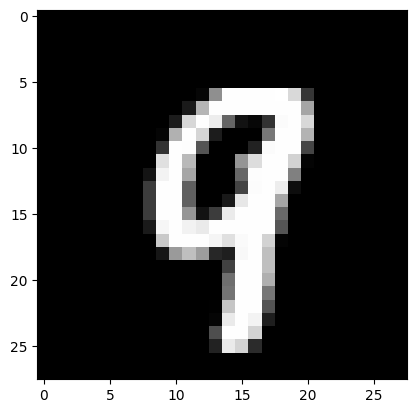

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [4]:
# checking shape of train and test
index = 800
plt.imshow(x_train[index],cmap='gray')
plt.show()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [5]:
# creating the generator using CNN layers
num =100
#weight_init = keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
channels = 1
def Generator():
  model= tf.keras.models.Sequential([
      # 1d array for random noise
      tfl.Dense(7*7*256, use_bias='False',input_shape=[num]),
      tfl.BatchNormalization(),
      tfl.LeakyReLU(),

      tfl.Reshape([7, 7, 256]),

      # upsample to 14x14
      tfl.Conv2DTranspose(128, (5,5), (1,1), padding="same"),
      tfl.BatchNormalization(),
      tfl.LeakyReLU(),

      # upsample to 28x28
      tfl.Conv2DTranspose(64, (5,5), (2,2), padding="same"),
      tfl.BatchNormalization(),
      tfl.LeakyReLU(),

      tfl.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
  ])
  return model

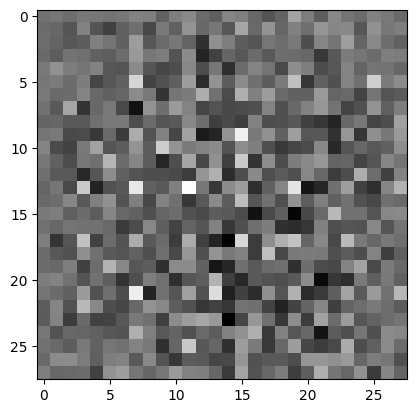

In [6]:
#initialising the generator
generator = Generator()
noise = tf.random.normal(shape=[1, num])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0],cmap='gray')

In [7]:
# creating the discriminator using CNN layers
def Discriminator():
    model = keras.models.Sequential([
        tfl.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
        tfl.LeakyReLU(0.2),
        tfl.Dropout(0.3),

        tfl.Conv2D(128, (5,5), (2,2), padding="same"),
        tfl.LeakyReLU(0.2),
        tfl.Dropout(0.3),

        tfl.Conv2D(256, (5,5), (1,1), padding="same"),
        tfl.LeakyReLU(0.2),
        tfl.Dropout(0.3),

        tfl.Flatten(),
        tfl.Dense(1, activation='sigmoid')
    ])
    return model


In [8]:
# initialising the discriminator
discriminator = Discriminator()
prob = discriminator(generated_image)
print(prob)

tf.Tensor([[0.50028795]], shape=(1, 1), dtype=float32)


In [9]:
# putting the generator and discriminator together
class DCGAN(keras.Model):
  def __init__(self,generator,discriminator, num):
    super().__init__()
    self.generator = generator
    self.discriminator = discriminator
    # self.g_metric = keras.metrics(name='g_loss')
    # self.d_metric = keras.Mean(name='d_loss')
    self.g_metric = keras.metrics.Mean(name='g_loss')
    self.d_metric = keras.metrics.Mean(name='d_loss')

  def metric(self):
    # return [g_metric,d_metric]
    return [self.g_metric, self.d_metric]

  def compile(self, g_optimizer,d_optimizer,loss):
    super(DCGAN,self).compile()


In [12]:
# training the now formed DCGAN
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, num):
        super().__init__()
        #generator = generator
        #discriminator = discriminator
        self.generator = generator
        self.discriminator = discriminator
        self.num = num
        self.g_metric = keras.metrics.Mean(name='g_loss')
        self.d_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        #return [g_metric,d_metric]
        return [self.g_metric, self.d_metric]

    def compile(self, g_optimizer, d_optimizer, loss):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss = loss

    def train_step(self, real_images):
        #batch_size = self.shape(real_images)[0]
        #batch_size = tf.shape(real_images[0])
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.num))

        # training the discriminator
        with tf.GradientTape() as tape:
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            real_labels += 0.05*tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss(real_labels, pred_real)

            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss(fake_labels, pred_fake)

            # calculating total loss by discriminator
            d_loss = (d_loss_real+d_loss_fake)/2


        # gradient descent for discriminator
        gradients = tape.gradient(d_loss,self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # training the generator
        labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)

            # calculating total loss by generator
            g_loss = self.loss(labels, pred_fake)

        # gradient descent for generator
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        self.d_metric.update_state(d_loss)
        self.g_metric.update_state(g_loss)

        return {'d_loss': self.d_metric.result(), 'g_loss': self.g_metric.result()}

In [13]:
# compiling and running it on train dataset
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self,num_imgs=25,latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        g_img = self.model.generator(self.noise)
        g_img = (g_img*127.5)+127.5
        #g_img.numpy()

        fig = plt.figure(figsize=(5,5))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            #img = array_to_img(g_img[i])
            plt.imshow(g_img[i],cmap='gray')
            plt.axis('off')
            # plt.savefig('Epoch.jpg'.format(i))
            # plt.close()
        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

Epoch 1/50
  5/625 [..............................] - ETA: 17s - d_loss: 0.6041 - g_loss: 0.5707

624/625 [============================>.] - ETA: 0s - d_loss: 840.4601 - g_loss: 8.2628

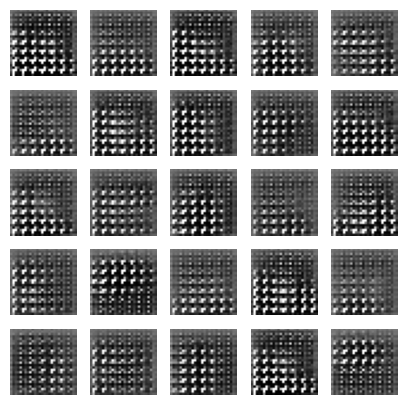

625/625 [==============================] - 18s 18ms/step - d_loss: 839.1903 - g_loss: 8.2573
Epoch 2/50
625/625 [==============================] - ETA: 0s - d_loss: 31.2845 - g_loss: 4.1108

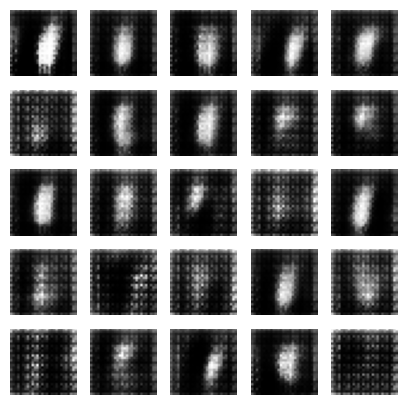

625/625 [==============================] - 11s 17ms/step - d_loss: 31.2845 - g_loss: 4.1108
Epoch 3/50
624/625 [============================>.] - ETA: 0s - d_loss: 45.8797 - g_loss: 13.6063

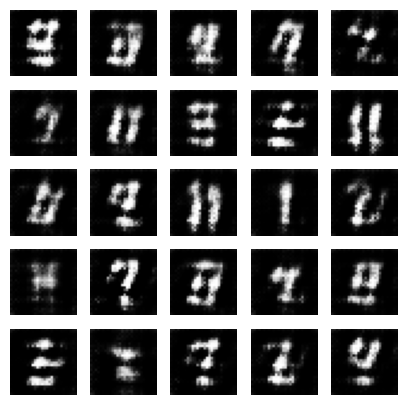

625/625 [==============================] - 11s 17ms/step - d_loss: 45.8610 - g_loss: 13.6092
Epoch 4/50
622/625 [============================>.] - ETA: 0s - d_loss: 18.5620 - g_loss: 8.3949

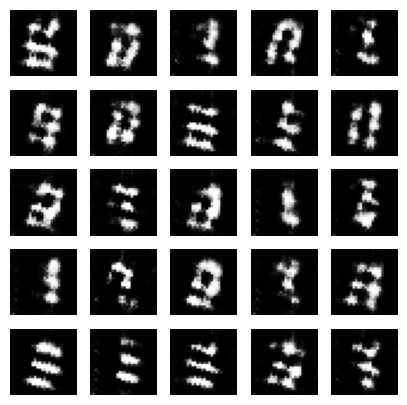

625/625 [==============================] - 12s 19ms/step - d_loss: 18.5146 - g_loss: 8.3765
Epoch 5/50
623/625 [============================>.] - ETA: 0s - d_loss: 8.1762 - g_loss: 5.3706

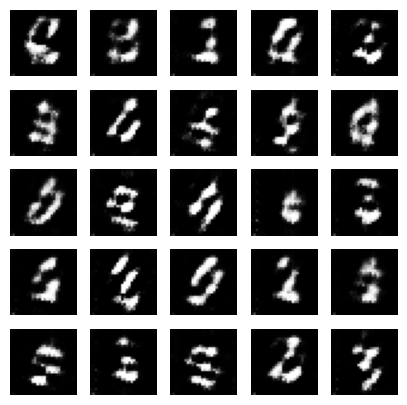

625/625 [==============================] - 12s 18ms/step - d_loss: 8.1666 - g_loss: 5.3614
Epoch 6/50
623/625 [============================>.] - ETA: 0s - d_loss: 4.0720 - g_loss: 3.3189

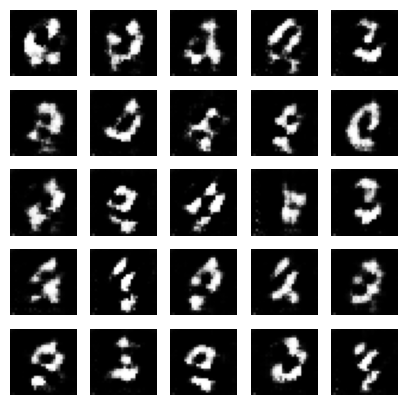

625/625 [==============================] - 11s 17ms/step - d_loss: 4.0671 - g_loss: 3.3191
Epoch 7/50
624/625 [============================>.] - ETA: 0s - d_loss: 3.4445 - g_loss: 2.8683

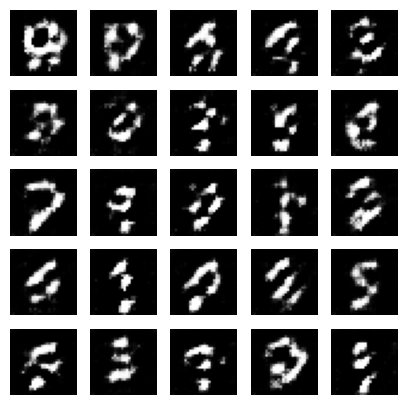

625/625 [==============================] - 11s 18ms/step - d_loss: 3.4416 - g_loss: 2.8674
Epoch 8/50
623/625 [============================>.] - ETA: 0s - d_loss: 2.8717 - g_loss: 2.7178

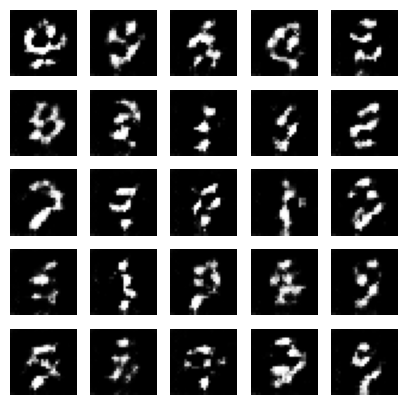

625/625 [==============================] - 11s 18ms/step - d_loss: 2.8699 - g_loss: 2.7186
Epoch 9/50
624/625 [============================>.] - ETA: 0s - d_loss: 2.4263 - g_loss: 2.6419

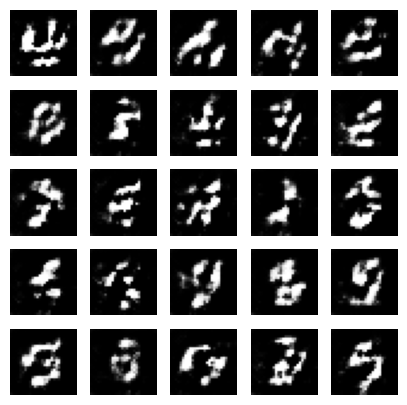

625/625 [==============================] - 11s 18ms/step - d_loss: 2.4259 - g_loss: 2.6415
Epoch 10/50
624/625 [============================>.] - ETA: 0s - d_loss: 1.8928 - g_loss: 2.3077

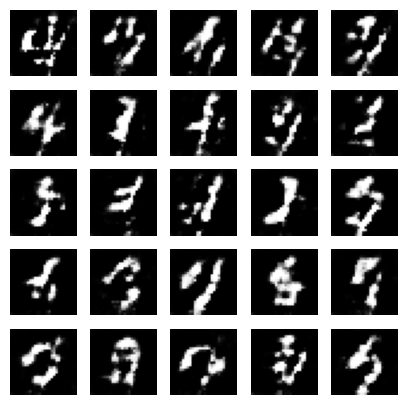

625/625 [==============================] - 12s 18ms/step - d_loss: 1.8921 - g_loss: 2.3075
Epoch 11/50
624/625 [============================>.] - ETA: 0s - d_loss: 1.7858 - g_loss: 2.1121

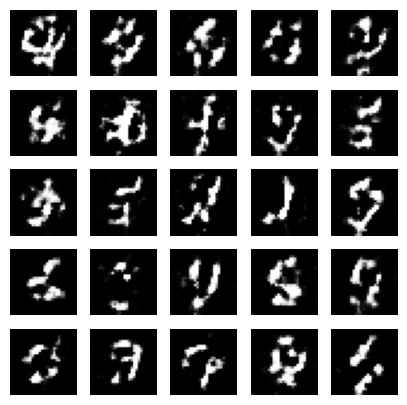

625/625 [==============================] - 11s 18ms/step - d_loss: 1.7852 - g_loss: 2.1138
Epoch 12/50
622/625 [============================>.] - ETA: 0s - d_loss: 1.5958 - g_loss: 1.8599

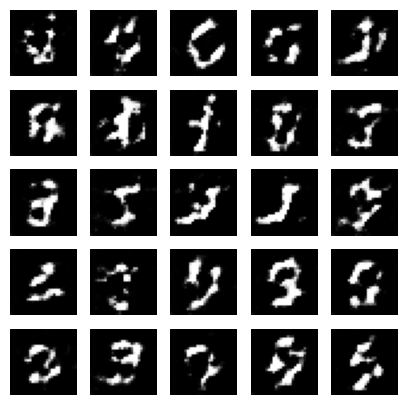

625/625 [==============================] - 11s 18ms/step - d_loss: 1.5970 - g_loss: 1.8573
Epoch 13/50
625/625 [==============================] - ETA: 0s - d_loss: 1.3770 - g_loss: 1.5891

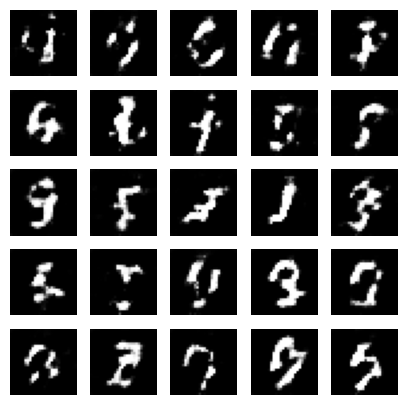

625/625 [==============================] - 11s 18ms/step - d_loss: 1.3770 - g_loss: 1.5891
Epoch 14/50
623/625 [============================>.] - ETA: 0s - d_loss: 1.0983 - g_loss: 1.2844

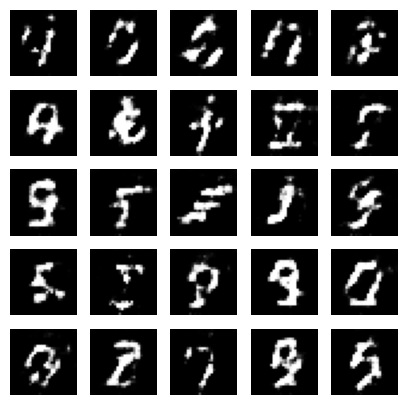

625/625 [==============================] - 11s 18ms/step - d_loss: 1.0986 - g_loss: 1.2837
Epoch 15/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.8791 - g_loss: 1.0396

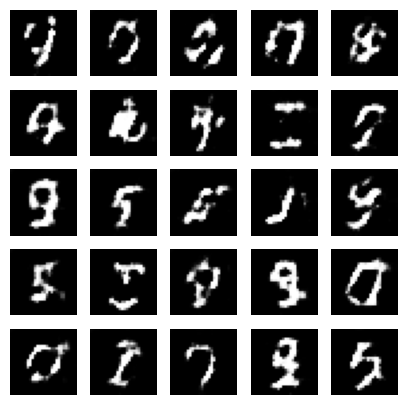

625/625 [==============================] - 11s 18ms/step - d_loss: 0.8786 - g_loss: 1.0390
Epoch 16/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.8028 - g_loss: 0.9338

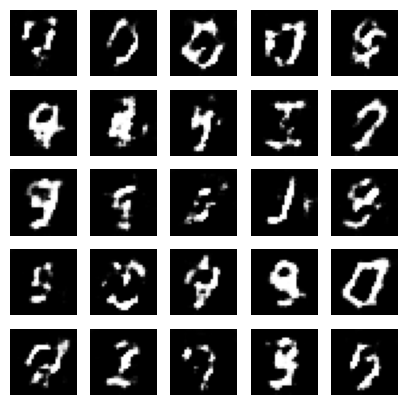

625/625 [==============================] - 11s 18ms/step - d_loss: 0.8026 - g_loss: 0.9333
Epoch 17/50
622/625 [============================>.] - ETA: 0s - d_loss: 0.7545 - g_loss: 0.8776

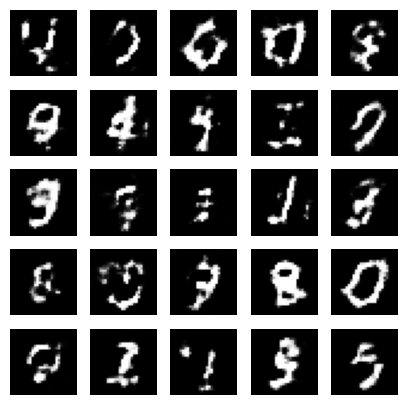

625/625 [==============================] - 11s 18ms/step - d_loss: 0.7543 - g_loss: 0.8774
Epoch 18/50
625/625 [==============================] - ETA: 0s - d_loss: 0.7273 - g_loss: 0.8551

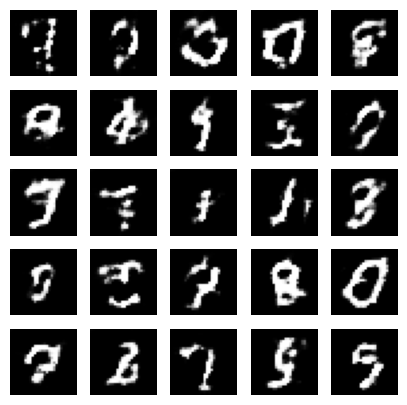

625/625 [==============================] - 11s 18ms/step - d_loss: 0.7273 - g_loss: 0.8551
Epoch 19/50
624/625 [============================>.] - ETA: 0s - d_loss: 0.7156 - g_loss: 0.8419

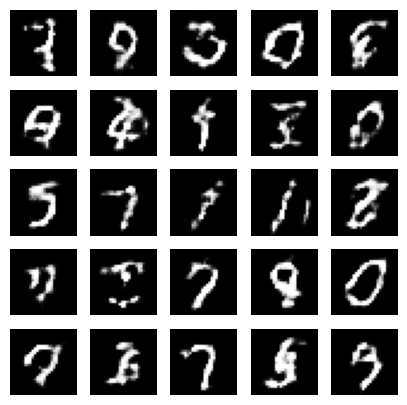

625/625 [==============================] - 11s 18ms/step - d_loss: 0.7157 - g_loss: 0.8418
Epoch 20/50
625/625 [==============================] - ETA: 0s - d_loss: 0.7161 - g_loss: 0.8283

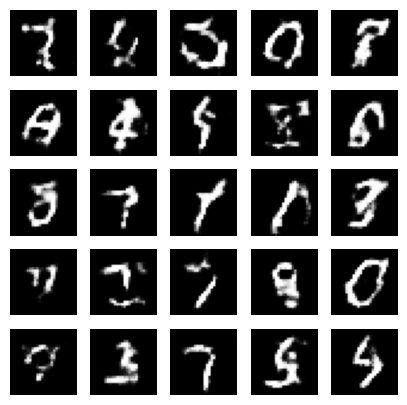

625/625 [==============================] - 11s 18ms/step - d_loss: 0.7161 - g_loss: 0.8283
Epoch 21/50
622/625 [============================>.] - ETA: 0s - d_loss: 0.7048 - g_loss: 0.8075

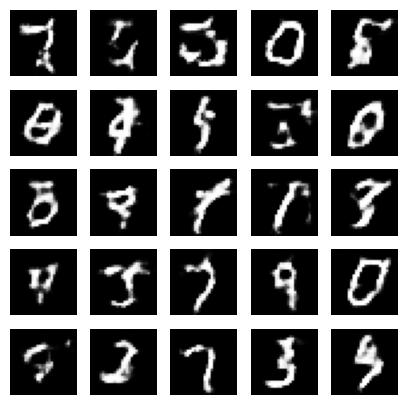

625/625 [==============================] - 11s 18ms/step - d_loss: 0.7047 - g_loss: 0.8075
Epoch 22/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.7022 - g_loss: 0.8133

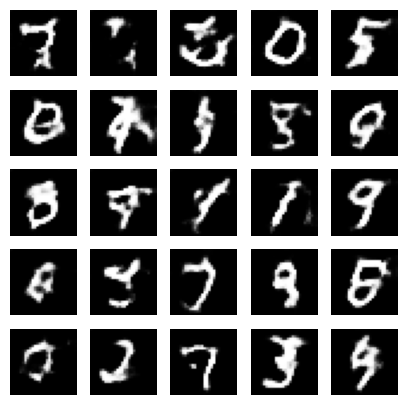

625/625 [==============================] - 11s 18ms/step - d_loss: 0.7022 - g_loss: 0.8135
Epoch 23/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.6936 - g_loss: 0.7968

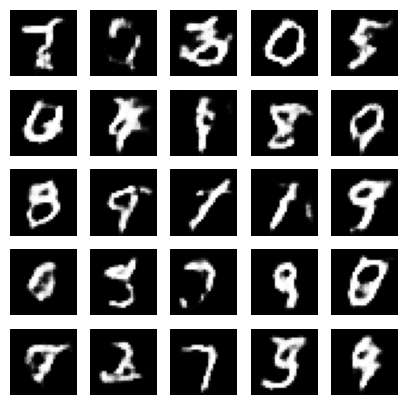

625/625 [==============================] - 12s 19ms/step - d_loss: 0.6935 - g_loss: 0.7967
Epoch 24/50
622/625 [============================>.] - ETA: 0s - d_loss: 0.6940 - g_loss: 0.8044

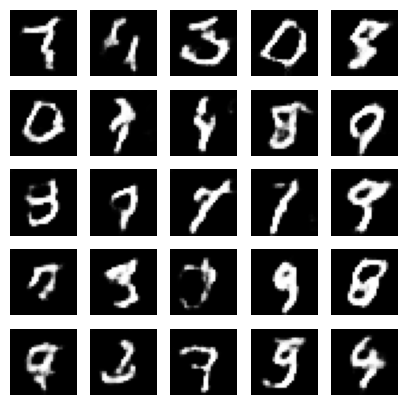

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6939 - g_loss: 0.8040
Epoch 25/50
624/625 [============================>.] - ETA: 0s - d_loss: 0.6860 - g_loss: 0.7933

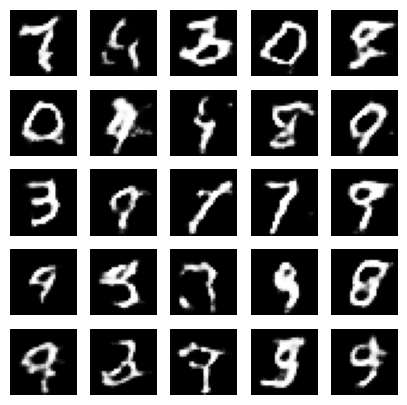

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6860 - g_loss: 0.7934
Epoch 26/50
624/625 [============================>.] - ETA: 0s - d_loss: 0.6837 - g_loss: 0.7832

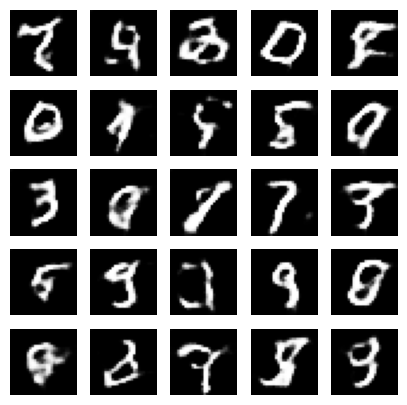

625/625 [==============================] - 12s 18ms/step - d_loss: 0.6838 - g_loss: 0.7832
Epoch 27/50
622/625 [============================>.] - ETA: 0s - d_loss: 0.6774 - g_loss: 0.7845

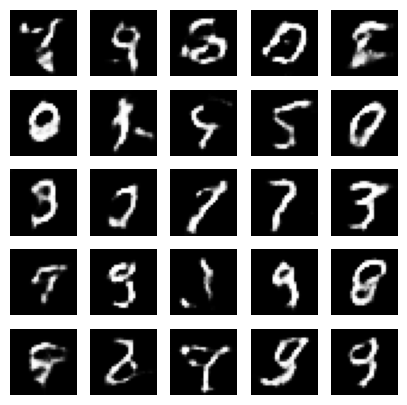

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6774 - g_loss: 0.7849
Epoch 28/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.6739 - g_loss: 0.8031

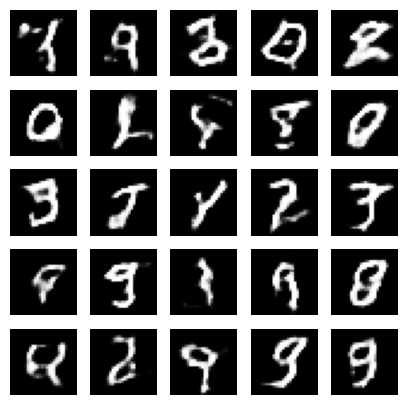

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6739 - g_loss: 0.8031
Epoch 29/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.6710 - g_loss: 0.8013

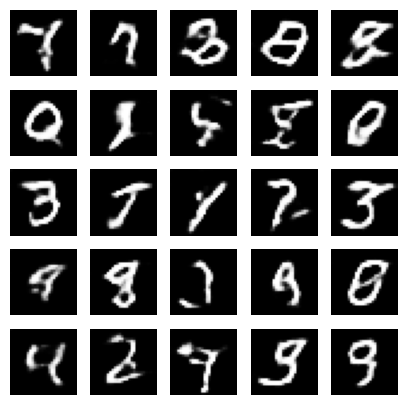

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6709 - g_loss: 0.8010
Epoch 30/50
625/625 [==============================] - ETA: 0s - d_loss: 0.6651 - g_loss: 0.7978

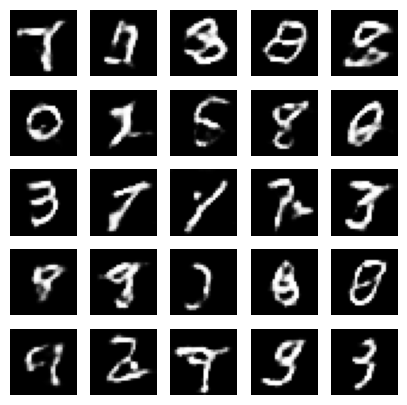

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6651 - g_loss: 0.7978
Epoch 31/50
625/625 [==============================] - ETA: 0s - d_loss: 0.6613 - g_loss: 0.8131

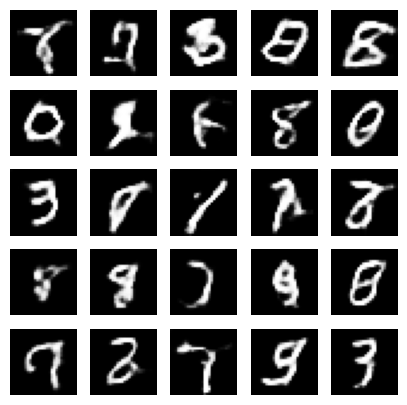

625/625 [==============================] - 12s 18ms/step - d_loss: 0.6613 - g_loss: 0.8131
Epoch 32/50
625/625 [==============================] - ETA: 0s - d_loss: 0.6555 - g_loss: 0.8158

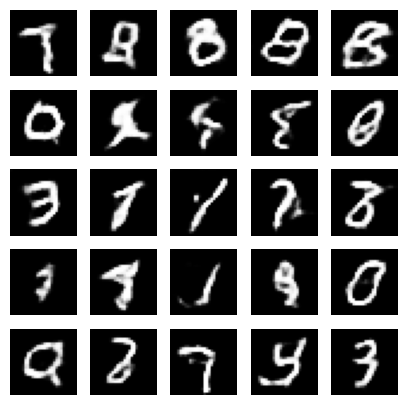

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6555 - g_loss: 0.8158
Epoch 33/50
624/625 [============================>.] - ETA: 0s - d_loss: 0.6493 - g_loss: 0.8337

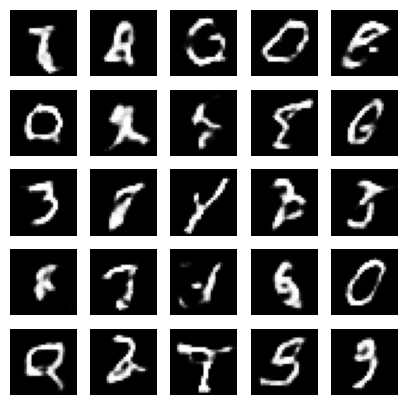

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6494 - g_loss: 0.8337
Epoch 34/50
624/625 [============================>.] - ETA: 0s - d_loss: 0.6431 - g_loss: 0.8407

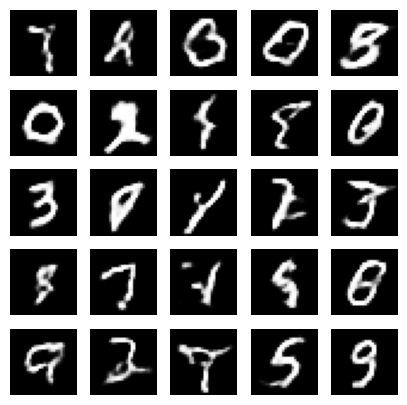

625/625 [==============================] - 12s 19ms/step - d_loss: 0.6431 - g_loss: 0.8407
Epoch 35/50
625/625 [==============================] - ETA: 0s - d_loss: 0.6385 - g_loss: 0.8595

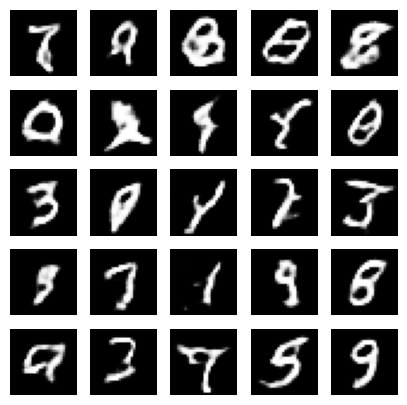

625/625 [==============================] - 12s 19ms/step - d_loss: 0.6385 - g_loss: 0.8595
Epoch 36/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.6341 - g_loss: 0.8662

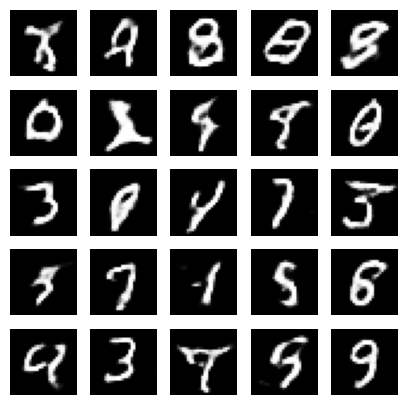

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6340 - g_loss: 0.8662
Epoch 37/50
625/625 [==============================] - ETA: 0s - d_loss: 0.6315 - g_loss: 0.8791

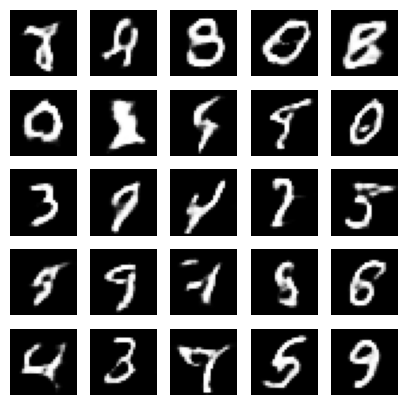

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6315 - g_loss: 0.8791
Epoch 38/50
625/625 [==============================] - ETA: 0s - d_loss: 0.6265 - g_loss: 0.8800

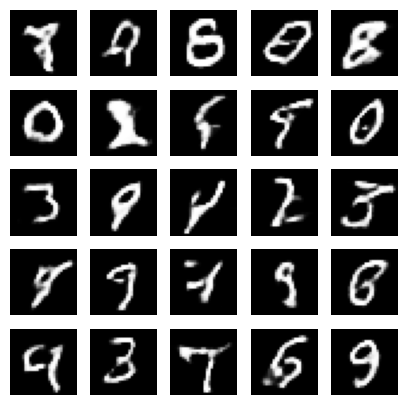

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6265 - g_loss: 0.8800
Epoch 39/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.6252 - g_loss: 0.8918

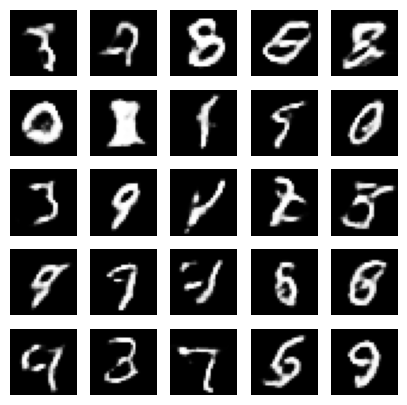

625/625 [==============================] - 12s 19ms/step - d_loss: 0.6252 - g_loss: 0.8918
Epoch 40/50
622/625 [============================>.] - ETA: 0s - d_loss: 0.6258 - g_loss: 0.8912

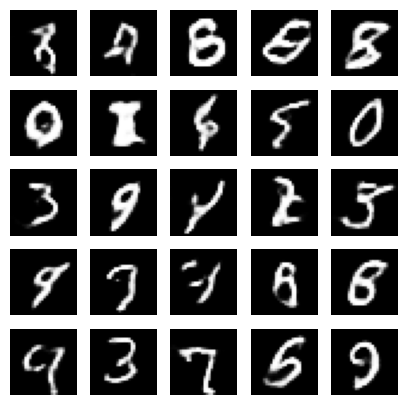

625/625 [==============================] - 12s 19ms/step - d_loss: 0.6258 - g_loss: 0.8906
Epoch 41/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.6233 - g_loss: 0.8905

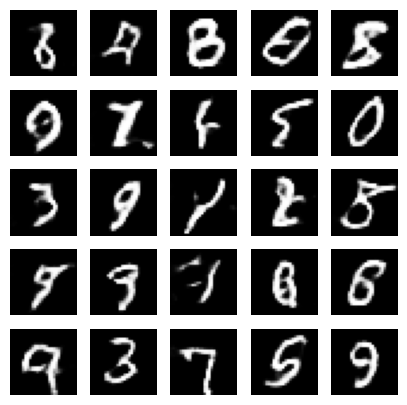

625/625 [==============================] - 12s 19ms/step - d_loss: 0.6233 - g_loss: 0.8904
Epoch 42/50
624/625 [============================>.] - ETA: 0s - d_loss: 0.6219 - g_loss: 0.8980

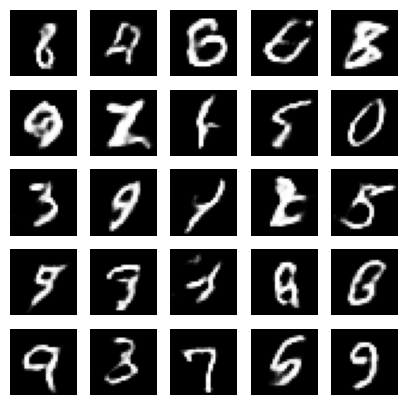

625/625 [==============================] - 12s 19ms/step - d_loss: 0.6219 - g_loss: 0.8979
Epoch 43/50
625/625 [==============================] - ETA: 0s - d_loss: 0.6189 - g_loss: 0.9076

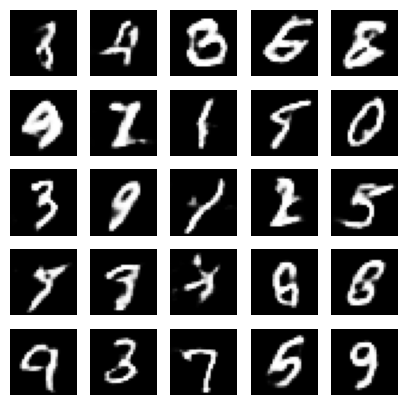

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6189 - g_loss: 0.9076
Epoch 44/50
622/625 [============================>.] - ETA: 0s - d_loss: 0.6172 - g_loss: 0.9033

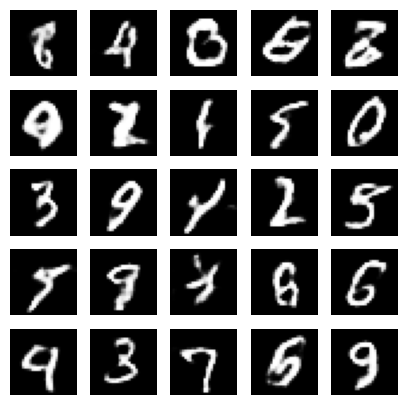

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6172 - g_loss: 0.9035
Epoch 45/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.6153 - g_loss: 0.9190

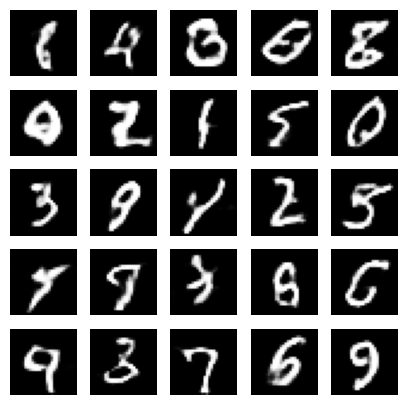

625/625 [==============================] - 12s 18ms/step - d_loss: 0.6154 - g_loss: 0.9189
Epoch 46/50
624/625 [============================>.] - ETA: 0s - d_loss: 0.6130 - g_loss: 0.9222

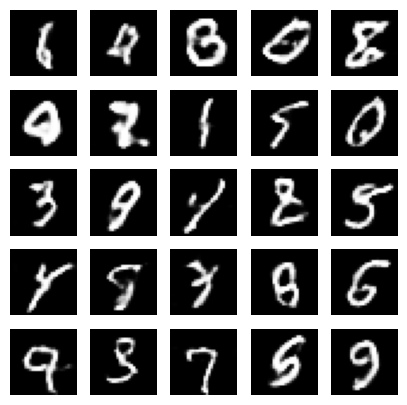

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6130 - g_loss: 0.9225
Epoch 47/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.6133 - g_loss: 0.9236

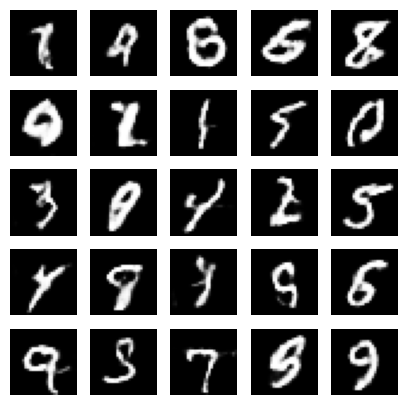

625/625 [==============================] - 12s 19ms/step - d_loss: 0.6133 - g_loss: 0.9233
Epoch 48/50
623/625 [============================>.] - ETA: 0s - d_loss: 0.6073 - g_loss: 0.9403

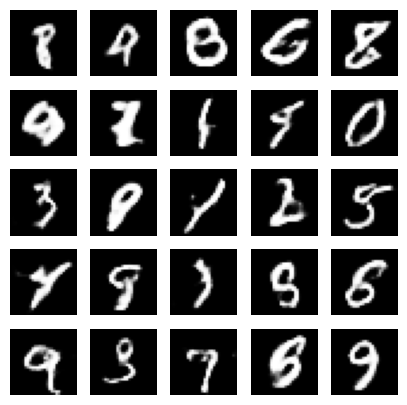

625/625 [==============================] - 12s 19ms/step - d_loss: 0.6073 - g_loss: 0.9398
Epoch 49/50
622/625 [============================>.] - ETA: 0s - d_loss: 0.6101 - g_loss: 0.9365

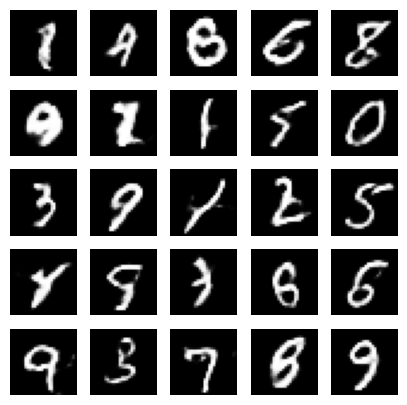

625/625 [==============================] - 11s 18ms/step - d_loss: 0.6100 - g_loss: 0.9367
Epoch 50/50
625/625 [==============================] - ETA: 0s - d_loss: 0.6080 - g_loss: 0.9312

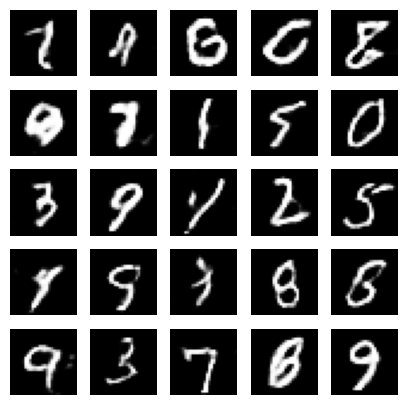

625/625 [==============================] - 12s 19ms/step - d_loss: 0.6080 - g_loss: 0.9312


In [14]:
# setting initial parameter values and then applying optimizers while compiling
dcgan = DCGAN(generator=generator, discriminator=discriminator, num=num)
d = 0.0001
g = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=g, beta_1=0.5), d_optimizer=Adam(learning_rate=d, beta_1=0.5), loss=BinaryCrossentropy())
number_epochs = 50
dcgan.fit(x_train[:20000], epochs=number_epochs , callbacks=[DCGANMonitor()])